In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import scipy.linalg
import scipy.fftpack
import scipy.optimize
import math
import time

In [3]:
p_gen = np.polynomial.chebyshev.Chebyshev

In [4]:
def calc_power_sums(xs, k):
    return np.array([
        np.sum(xs**i) for i in range(k)
    ])
def calc_cheby_sums(xs, k):
    return np.array([
        np.sum(p_gen.basis(i)(xs)) for i in range(k)
    ])

In [5]:
maxk = 31
cheby_coeffs = [
    np.array([1]),
    np.array([0,1]),
]
for i in range(2,maxk+1):
    Tn1 = cheby_coeffs[-1]
    Tn2 = cheby_coeffs[-2]
    cheby_coeffs.append(
        np.insert(2*Tn1,0,0) 
        - np.concatenate([Tn2,[0,0]])
    )

In [6]:
def shift(
    ms, xmin, xmax
):
    k = len(ms) - 1
    r = (xmax - xmin) / 2
    xc = (xmax + xmin) / 2
    ms_scaled = np.zeros(k+1)
    nxc_powers = np.power(-xc, np.arange(0,k+1))
    for m in range(k+1):
        ms_scaled[m] = np.sum(
            scipy.special.binom(m, np.arange(0,m+1)) 
            * nxc_powers[:m+1][::-1]
            * ms[:m+1]
        ) * math.pow(r,-m)
    return ms_scaled
def shifted_to_cheby(
    ms_scaled
):
    k = len(ms_scaled) - 1
    ms_cheby = np.zeros(k+1)
    for i in range(k+1):
        ms_cheby[i] = np.inner(
            cheby_coeffs[i], ms_scaled[:i+1]
        )
    return ms_cheby

In [7]:
def compare_methods(xs, k):
    xmin = np.min(xs)
    xmax = np.max(xs)
    xc = (xmin + xmax)/2
    xr = (xmax - xmin)/2
    axs = (xs - xc)/xr
    mus_a = [np.mean(axs**i) for i in range(k)]
    
    mus_x = [np.mean(xs**i) for i in range(k)]
    mus_xa = shift(mus_x, xmin, xmax)
    
    rel_error = np.abs((mus_a - mus_xa)) * np.power(3, np.arange(k))
    
    max_k = k-1
    for i in range(2,k):
        if rel_error[i] > (1.0/(i-1) - 1.0/(i)):
            max_k = i-1
            break
    
    return max_k

In [8]:
def maxk_formula2(cs):
    return (53*np.log10(2) - 2.58)/(np.log10(6) + np.log10(np.abs(cs)+1))

In [9]:
def maxk_formula(c):
    l_eps = 52*np.log10(2)
    for i in range(2,40):
        lhs = i*(np.log10(6) + np.log10(np.abs(c)+1)) + np.log10(i*i - i)
        if lhs > l_eps:
            max_k = i-1
            break
    return max_k

In [10]:
def maxk_empirical(c):
    k = 40
    x1 = np.linspace(-1+c,c+1,100001)
    maxk = compare_methods(x1, k)
    return maxk

In [18]:
x1 = np.random.uniform(size=100001)
xs = (np.max(x1) - np.min(x1))/2
xc = (np.min(x1) + np.max(x1))/2
x1 = (x1-xc)/xs
def maxk_empirical_g(c):
    k = 40
    maxk = compare_methods(x1+c, k)
    return maxk

In [20]:
cs = np.linspace(0, 10, 40)
# cs_f = np.array([maxk_formula2(c) for c in cs])
# cs_eg = np.array([maxk_empirical_g(c) for c in cs])
cs_e = np.array([maxk_empirical(c) for c in cs])
cs_f2 = maxk_formula2(cs)

In [21]:
maxk_formula2(2)

10.654730121002933

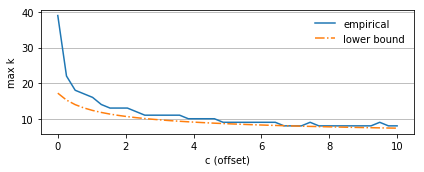

In [22]:
fig = plt.figure(figsize=(6,2.5))
ax = fig.gca()
# ax.plot(cs, cs_f, label="f")
ax.plot(cs, cs_e, label="empirical")
# ax.plot(cs, cs_eg, label="empirical g")
ax.plot(cs, cs_f2, label="lower bound", ls="-.")
ax.legend(frameon=False)
ax.set_xlabel("c (offset)")
ax.set_ylabel("max k")
# ax.set_ylim(0, 35)
ax.yaxis.grid(True)
fig.tight_layout()
fig.savefig("maxk.pdf")

In [143]:
k1 = 52*np.log10(2) / np.log10(6)
np.log10(k1*k1 - k1)

2.584953978315502

In [7]:
x1 = np.linspace(0,1000,1001)
s1 = calc_power_sums(x1, 4).astype(int)
print(repr(s1))


array([        1001,       500500,    333833500, 250500250000])


In [91]:
x1 = np.linspace(0,1000,1001)
s1 = calc_power_sums(x1, 4).astype(int)
print(repr(s1))
print(shifted_to_cheby(shift(s1, np.min(x1), np.max(x1)))/1001.0)

array([        1001,       500500,    333833500, 250500250000])
[ 1.     0.    -0.332  0.   ]


In [93]:
x2 = np.linspace(-1,1,1001)
calc_cheby_sums(x2, 4)/1001.0

array([  1.00000000e+00,   2.83933161e-17,  -3.32000000e-01,
         2.83933161e-17])

In [67]:
df = pd.read_csv("../sampledata/uci_retail_cleaned.csv")
data = np.array(df["x"],dtype="float64")

In [77]:
dmin = np.min(data)
dmax = np.max(data)
dc = (dmax+dmin)/2
dr = (dmax-dmin)/2
ndata = (data - dc) /dr
calc_cheby_sums(ndata, 10)[6]

509831.77099894051

In [78]:
s1 = calc_power_sums(data, 10)
shifted_to_cheby(shift(
    s1, np.min(data), np.max(data)))[6]

509831.77099894546